In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/content/drive/MyDrive/project_data"

PRICE_DIRS = {
    'crypto':  f"{DATA_DIR}/crypto",
    'equity':  f"{DATA_DIR}/equity",
    'etf':     f"{DATA_DIR}/etf",
    'futures': f"{DATA_DIR}/futures",
    'fx':      f"{DATA_DIR}/fx",
    'index':   f"{DATA_DIR}/index",
}

def load_asset(ticker):
    # 1. Look up metadata
    row = meta[meta["Ticker"] == ticker]
    if row.empty:
        raise ValueError(f"Ticker {ticker} not found in metadata")

    asset_class = row["PrimaryAssetClass"].values[0].lower()  # e.g. 'futures'
    folder = PRICE_DIRS.get(asset_class)
    if folder is None:
        raise ValueError(f"No folder mapping for asset class: {asset_class}")

    # 2. Try parquet then csv
    parquet_path = f"{folder}/{ticker}.parquet"
    csv_path = f"{folder}/{ticker}.csv"

    if os.path.exists(parquet_path):
        print("Loading:", parquet_path)
        df = pd.read_parquet(parquet_path)
    elif os.path.exists(csv_path):
        print("Loading:", csv_path)
        df = pd.read_csv(csv_path)
    else:
        raise FileNotFoundError(f"No .parquet or .csv found for {ticker} in {folder}")

    # 3. Normalize time column name: ts -> timestamp
    if 'ts' in df.columns:
        df = df.rename(columns={'ts': 'timestamp'})

    # 4. Force to datetime and strip timezone if present
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    # drop timezone to make it naive (optional but often simpler)
    df['timestamp'] = df['timestamp'].dt.tz_convert(None)

    # 5. Sort + compute returns
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['ret'] = df['close'].pct_change()

    return df

In [3]:
meta = pd.read_csv(f"{DATA_DIR}/symbol_metadata.csv")
if 'Unnamed: 0' in meta.columns:
    meta = meta.drop(columns=['Unnamed: 0'])

In [4]:
df = load_asset("ES")
df.head()

Loading: /content/drive/MyDrive/project_data/futures/ES.parquet


,timestamp,open,high,low,close,volume,asset_class,symbol,year,month,ret
0,2013-01-02 11:00:00,1791.25,1792.00,1786.50,1788.50,20926.0,futures,ES,2013,1,NaN
1,2013-01-02 11:01:00,1788.50,1790.00,1788.25,1789.50,7261.0,futures,ES,2013,1,0.000559
2,2013-01-02 11:02:00,1789.50,1791.50,1789.25,1791.50,5010.0,futures,ES,2013,1,0.001118
3,2013-01-02 11:03:00,1791.50,1793.25,1791.25,1792.75,7733.0,futures,ES,2013,1,0.000698
4,2013-01-02 11:04:00,1792.75,1792.75,1791.75,1792.25,4748.0,futures,ES,2013,1,-0.000279


Loading: /content/drive/MyDrive/project_data/futures/ES.parquet
                        timestamp         close           ret
count                     4399957  4.399957e+06  4.399956e+06
mean   2019-04-24 06:49:38.205195  3.662521e+03  3.246585e-07
min           2013-01-02 11:00:00  1.788500e+03 -4.507373e-02
25%           2016-03-01 17:29:00  2.512250e+03 -9.388790e-05
50%           2019-05-01 14:31:00  3.320750e+03  0.000000e+00
75%           2022-06-16 11:48:00  4.741250e+03  9.519277e-05
max           2025-07-25 20:59:00  6.430250e+03  2.553546e-02
std                           NaN  1.250102e+03  2.603252e-04


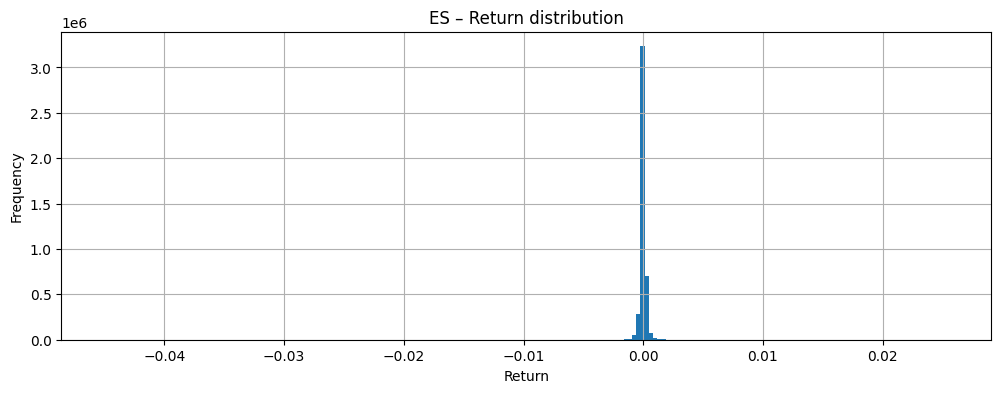

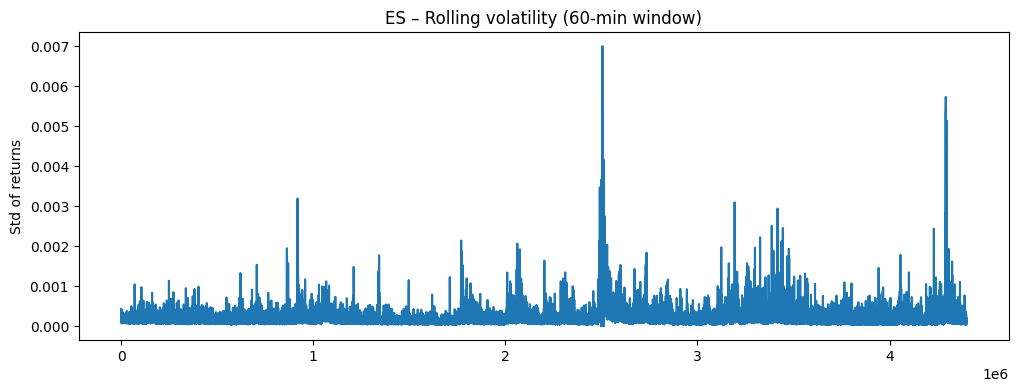

In [5]:
plt.rcParams['figure.figsize'] = (12, 4)

def basic_eda(ticker):
    df = load_asset(ticker)
    print(df[['timestamp','close','ret']].describe())

    # Return distribution
    df['ret'].hist(bins=200)
    plt.title(f"{ticker} – Return distribution")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.show()

    # Rolling volatility (e.g. 60-minute window)
    df['ret'].rolling(60).std().plot()
    plt.title(f"{ticker} – Rolling volatility (60-min window)")
    plt.ylabel("Std of returns")
    plt.show()

basic_eda("ES")

Loading: /content/drive/MyDrive/project_data/futures/NQ.parquet
                        timestamp         close           ret
count                     4305489  4.305489e+06  4.305488e+06
mean   2019-05-30 14:07:55.501613  1.184406e+04  3.923908e-07
min           2013-01-02 11:00:00  5.155750e+03 -4.389658e-02
25%           2016-04-28 03:45:00  7.113500e+03 -7.977049e-05
50%           2019-06-19 07:04:00  1.004750e+04  0.000000e+00
75%           2022-07-12 02:59:00  1.617475e+04  8.239608e-05
max           2025-07-25 20:59:00  2.347425e+04  2.635068e-02
std                           NaN  5.088402e+03  2.852272e-04


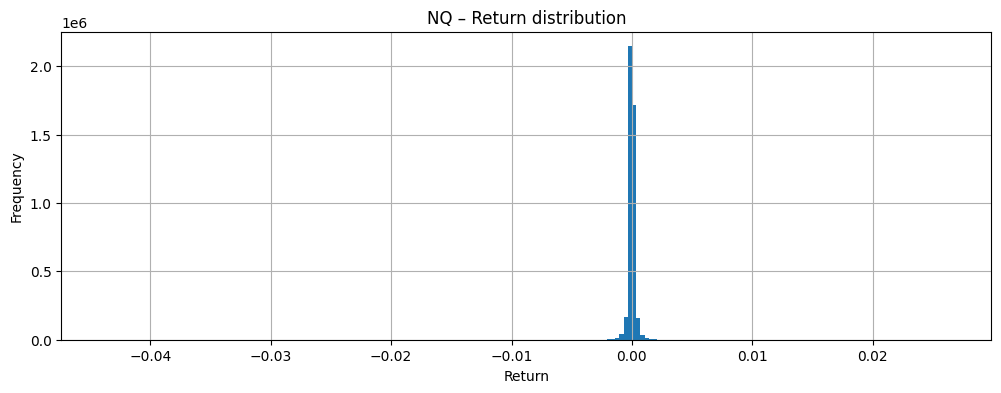

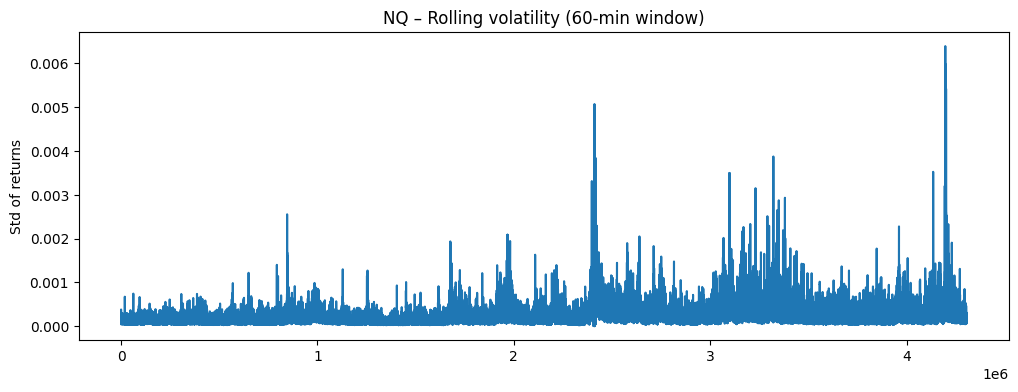

Loading: /content/drive/MyDrive/project_data/futures/RTY.parquet
                        timestamp         close           ret
count                     3775829  3.775829e+06  3.775828e+06
mean   2019-09-21 06:42:05.865806  1.806642e+03  2.866852e-07
min           2013-01-02 11:00:00  1.012100e+03 -4.536672e-02
25%           2016-09-23 16:28:00  1.447200e+03 -1.302140e-04
50%           2019-12-27 14:34:00  1.788200e+03  0.000000e+00
75%           2022-10-10 10:01:00  2.113000e+03  1.343905e-04
max           2025-07-25 20:59:00  2.671400e+03  3.178085e-02
std                           NaN  3.876633e+02  3.805793e-04


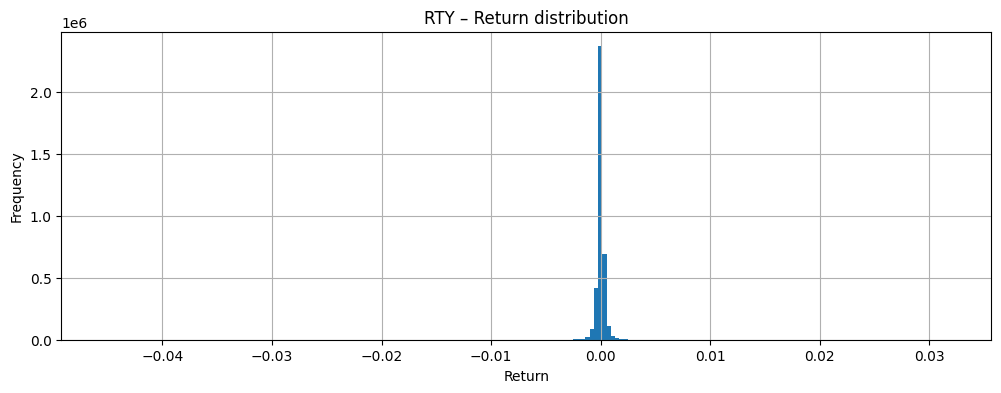

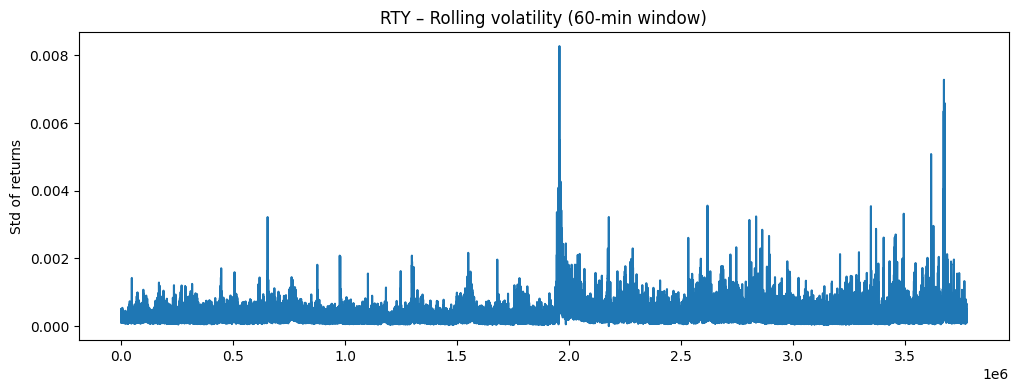

Loading: /content/drive/MyDrive/project_data/futures/BTC.parquet
                        timestamp         close           ret
count                     1563200  1.563200e+06  1.563199e+06
mean   2022-02-15 22:51:51.362178  5.237630e+04  1.208142e-06
min           2017-12-22 05:00:00  2.219500e+04 -6.701643e-02
25%           2020-06-12 14:26:45  2.977000e+04 -3.274930e-04
50%           2022-03-22 18:34:30  4.632000e+04  0.000000e+00
75%           2023-12-13 03:55:45  6.841000e+04  3.276182e-04
max           2025-07-25 20:59:00  1.237500e+05  1.174094e-01
std                           NaN  2.422280e+04  8.944528e-04


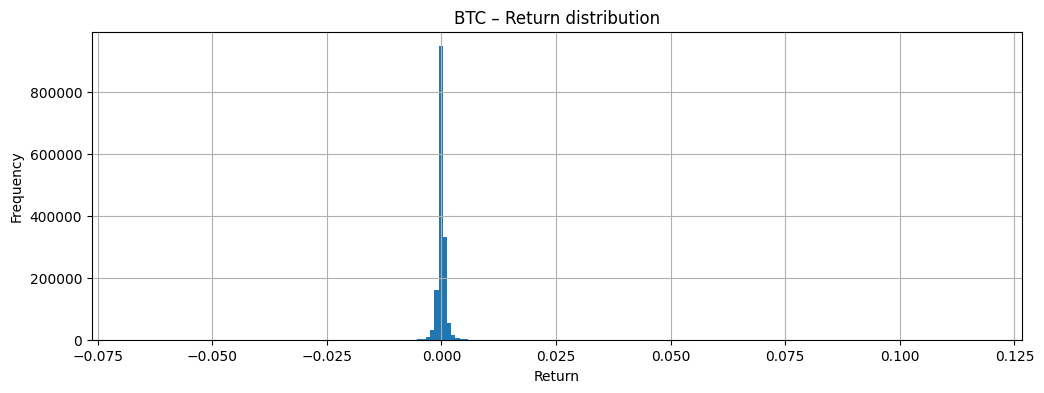

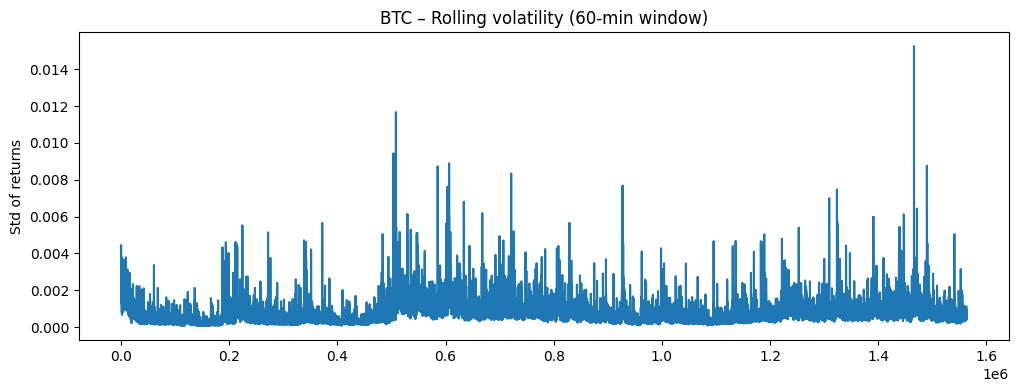

In [6]:
basic_eda("NQ")
basic_eda("RTY")
basic_eda("BTC")   # futures-style BTC contract in your futures folder

In [7]:
# Take up to 3 instruments per asset class for a toy universe
N_PER_CLASS = 3
sample_universe = (
    meta.groupby("PrimaryAssetClass")
        .head(N_PER_CLASS)
        .reset_index(drop=True)
)

sample_universe

,Ticker,Name,PrimaryAssetClass,Category
0,NQ,Nasdaq 100 Futures (continuous),futures,INDICES
1,ES,S&P 500 Futures (continuous),futures,INDICES
2,YM,Dow Jones Futures (continuous),futures,INDICES
3,AAPL,Apple Inc.,equity,MAG 7
4,MSFT,Microsoft Corp.,equity,MAG 7
5,AMZN,Amazon.com Inc.,equity,MAG 7
6,XLK,Technology Select Sector SPDR,etf,SECTORS
7,XLC,Communication Services Select Sector SPDR,etf,SECTORS
8,XLY,Consumer Discretionary Select Sector SPDR,etf,SECTORS
9,USDJPY,USDJPY,fx,USD FX


In [8]:
tickers = ["ES", "USDJPY", "USDCAD", "VIX", "GVZ"]

# Load each asset and keep only timestamp + ret
dfs = {}
for t in tickers:
    df_t = load_asset(t)[['timestamp', 'ret']].rename(columns={'ret': f'ret_{t}'})
    dfs[t] = df_t

# Merge on timestamp
combined = dfs[tickers[0]]
for t in tickers[1:]:
    combined = combined.merge(dfs[t], on='timestamp', how='inner')

combined.head()

Loading: /content/drive/MyDrive/project_data/futures/ES.parquet
Loading: /content/drive/MyDrive/project_data/fx/USDJPY.parquet
Loading: /content/drive/MyDrive/project_data/fx/USDCAD.parquet
Loading: /content/drive/MyDrive/project_data/index/VIX.parquet
Loading: /content/drive/MyDrive/project_data/index/GVZ.parquet


,timestamp,ret_ES,ret_USDJPY,ret_USDCAD,ret_VIX,ret_GVZ
0,2013-01-02 14:31:00,0.000417,0.000023,-0.000112,NaN,NaN
1,2013-01-02 14:32:00,-0.000417,0.000126,0.000010,0.000000,-0.001396
2,2013-01-02 14:33:00,0.000000,-0.000046,0.000081,0.003934,0.000000
3,2013-01-02 14:34:00,0.000557,-0.000092,0.000041,-0.000653,-0.000699
4,2013-01-02 14:35:00,0.000556,0.000069,-0.000142,-0.004575,0.001399


In [9]:
ret_cols = [c for c in combined.columns if c.startswith("ret_")]
corr = combined[ret_cols].dropna().corr()
corr

,ret_ES,ret_USDJPY,ret_USDCAD,ret_VIX,ret_GVZ
ret_ES,1.000000,0.196781,-0.328909,-0.439875,-0.008793
ret_USDJPY,0.196781,1.000000,0.169713,-0.123120,-0.011786
ret_USDCAD,-0.328909,0.169713,1.000000,0.167915,-0.003575
ret_VIX,-0.439875,-0.123120,0.167915,1.000000,0.034494
ret_GVZ,-0.008793,-0.011786,-0.003575,0.034494,1.000000


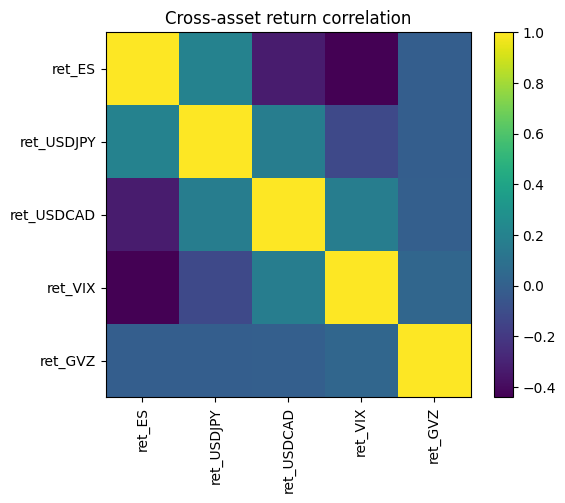

In [10]:
plt.figure(figsize=(6,5))
im = plt.imshow(corr, interpolation='nearest')
plt.colorbar(im)
plt.xticks(range(len(ret_cols)), ret_cols, rotation=90)
plt.yticks(range(len(ret_cols)), ret_cols)
plt.title("Cross-asset return correlation")
plt.tight_layout()
plt.show()

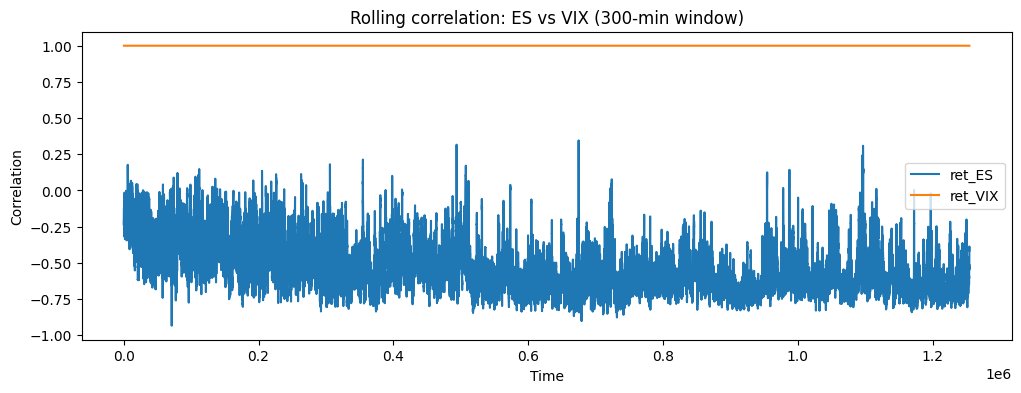

In [11]:
sym1, sym2 = "ES", "VIX"   # or "ES", "USDJPY", etc.
col1, col2 = f"ret_{sym1}", f"ret_{sym2}"

rolling_corr = (
    combined[[col1, col2]]
    .dropna()
    .rolling(300)
    .corr()
    .unstack()[col2]  # correlation of col1 vs col2
)

rolling_corr.plot()
plt.title(f"Rolling correlation: {sym1} vs {sym2} (300-min window)")
plt.ylabel("Correlation")
plt.xlabel("Time")
plt.show()

In [12]:
# 30-minute forward return of ES
combined["target_ES_30m"] = combined["ret_ES"].shift(-30)

# Also create a classification target: 1 = up, 0 = down
combined["target_ES_30m_updown"] = (combined["target_ES_30m"] > 0).astype(int)

# 1-lag returns for each asset
combined["lag_ES"]      = combined["ret_ES"].shift(1)
combined["lag_USDJPY"]  = combined["ret_USDJPY"].shift(1)
combined["lag_USDCAD"]  = combined["ret_USDCAD"].shift(1)
combined["lag_VIX"]     = combined["ret_VIX"].shift(1)
combined["lag_GVZ"]     = combined["ret_GVZ"].shift(1)
combined["vol_ES_60"] = combined["ret_ES"].rolling(60).std()

features = [
    "lag_ES", "lag_USDJPY", "lag_USDCAD",
    "lag_VIX", "lag_GVZ",
    "vol_ES_60"
]

target = "target_ES_30m_updown"  # classification

# Drop any rows with NA values (from lags & rolling windows)
df = combined.dropna(subset=features + [target])

X = df[features]
y = df[target]

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

tscv = TimeSeriesSplit(n_splits=5)

accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

accuracies

[0.5972693144592429,
 0.5940221419860835,
 0.5604457090935177,
 0.5362090815618947,
 0.5323736878601659]

In [13]:
coef_table = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_[0]
})
coef_table

,feature,coefficient
0,lag_ES,-3.425196e-06
1,lag_USDJPY,-2.095254e-07
2,lag_USDCAD,1.022938e-06
3,lag_VIX,3.733315e-05
4,lag_GVZ,-1.669026e-05
5,vol_ES_60,-4.974838e-05


In [14]:
# Regression target: 30-min forward ES return
reg_target = "target_ES_30m"

# Make sure we drop rows where either features OR regression target are NaN
df_reg = combined.dropna(subset=features + [reg_target])

X_reg = df_reg[features]
y_reg = df_reg[reg_target]

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

rmses = []

for train_idx, test_idx in tscv.split(X_reg):
    X_train, X_test = X_reg.iloc[train_idx], X_reg.iloc[test_idx]
    y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    reg = LinearRegression()
    reg.fit(X_train, y_train)

    preds_reg = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds_reg))
    rmses.append(rmse)

rmses

[np.float64(0.0002893900935973883),
 np.float64(0.0003020227217720331),
 np.float64(0.0004833609021473425),
 np.float64(0.0004179502965972757),
 np.float64(0.00037353784324844564)]

In [15]:
# ==== FEATURE ENGINEERING ====
# Assumes `combined` has:
# ['timestamp', 'ret_ES', 'ret_USDJPY', 'ret_USDCAD', 'ret_VIX', 'ret_GVZ']

# 1. Lagged returns (1-step lags)
combined["lag_ES"]      = combined["ret_ES"].shift(1)
combined["lag_USDJPY"]  = combined["ret_USDJPY"].shift(1)
combined["lag_USDCAD"]  = combined["ret_USDCAD"].shift(1)
combined["lag_VIX"]     = combined["ret_VIX"].shift(1)
combined["lag_GVZ"]     = combined["ret_GVZ"].shift(1)

# 2. Rolling volatility (standard deviation of returns)
# Windows in minutes: 60, 120, 300
vol_windows = [60, 120, 300]

for w in vol_windows:
    combined[f"vol_ES_{w}"]     = combined["ret_ES"].rolling(w).std()
    combined[f"vol_USDJPY_{w}"] = combined["ret_USDJPY"].rolling(w).std()
    combined[f"vol_USDCAD_{w}"] = combined["ret_USDCAD"].rolling(w).std()
    combined[f"vol_VIX_{w}"]    = combined["ret_VIX"].rolling(w).std()
    combined[f"vol_GVZ_{w}"]    = combined["ret_GVZ"].rolling(w).std()

# 3. Rolling correlations with ES (cross-asset signals)
# ES vs VIX, ES vs USDJPY, ES vs USDCAD
corr_windows = [60, 300]

for w in corr_windows:
    combined[f"corr_ES_VIX_{w}"]    = combined["ret_ES"].rolling(w).corr(combined["ret_VIX"])
    combined[f"corr_ES_USDJPY_{w}"] = combined["ret_ES"].rolling(w).corr(combined["ret_USDJPY"])
    combined[f"corr_ES_USDCAD_{w}"] = combined["ret_ES"].rolling(w).corr(combined["ret_USDCAD"])

# 4. Momentum features for ES (sum of returns over last k minutes)
# Interpreted roughly like short-term trend
mom_windows = [5, 10, 30]

for w in mom_windows:
    combined[f"mom_ES_{w}"] = combined["ret_ES"].rolling(w).sum()

# 5. Simple volatility regime indicator (high vs low vol)
# Use long-window ES volatility as regime signal
regime_vol_col = "vol_ES_300"

# Compute threshold as, e.g., 70th percentile of vol_ES_300 (ignoring NaNs)
vol_threshold = combined[regime_vol_col].quantile(0.7)

# High-vol regime = 1, else 0
combined["regime_high_vol"] = (combined[regime_vol_col] > vol_threshold).astype(int)

# 6. (Optional) Drop very early rows where all rolling windows are NaN
# You can do this later right before modeling, depending on which features you select.


In [16]:
feature_cols = [
    # lags
    "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ",

    # ES volatility
    "vol_ES_60", "vol_ES_120", "vol_ES_300",

    # VIX & FX volatility
    "vol_VIX_60", "vol_VIX_120", "vol_VIX_300",
    "vol_USDJPY_60", "vol_USDJPY_120", "vol_USDJPY_300",
    "vol_USDCAD_60", "vol_USDCAD_120", "vol_USDCAD_300",

    # cross-asset correlations
    "corr_ES_VIX_60", "corr_ES_VIX_300",
    "corr_ES_USDJPY_60", "corr_ES_USDJPY_300",
    "corr_ES_USDCAD_60", "corr_ES_USDCAD_300",

    # momentum
    "mom_ES_5", "mom_ES_10", "mom_ES_30",

    # regime flag
    "regime_high_vol",
]

# Build clean modeling dataframe (example for classification)
target = "target_ES_30m_updown"  # from earlier

df_model = combined.dropna(subset=feature_cols + [target])

X = df_model[feature_cols]
y = df_model[target]

In [17]:
combined.tail()

,timestamp,ret_ES,ret_USDJPY,ret_USDCAD,ret_VIX,ret_GVZ,target_ES_30m,target_ES_30m_updown,lag_ES,lag_USDJPY,...,corr_ES_VIX_60,corr_ES_USDJPY_60,corr_ES_USDCAD_60,corr_ES_VIX_300,corr_ES_USDJPY_300,corr_ES_USDCAD_300,mom_ES_5,mom_ES_10,mom_ES_30,regime_high_vol
1254689,2025-07-25 19:56:00,0.000389,-0.000075,-0.000102,-0.003324,0.000000,NaN,0,-0.000156,0.000102,...,-0.355383,0.032027,-0.302262,-0.423489,-0.118091,-0.146098,0.000039,-0.000467,-0.000467,0
1254690,2025-07-25 19:57:00,0.000117,0.000102,0.000044,-0.001334,0.000000,NaN,0,0.000389,-0.000075,...,-0.371451,0.044104,-0.294809,-0.430040,-0.104858,-0.149513,0.000195,-0.000428,-0.000311,0
1254691,2025-07-25 19:58:00,-0.000272,0.000020,-0.000066,-0.000668,0.000000,NaN,0,0.000117,0.000102,...,-0.323481,0.027383,-0.226911,-0.417977,-0.105343,-0.139192,-0.000117,-0.000622,-0.000583,0
1254692,2025-07-25 19:59:00,0.000156,0.000075,-0.000015,0.000000,-0.001172,NaN,0,-0.000272,0.000020,...,-0.304643,0.053978,-0.221954,-0.417252,-0.097367,-0.143642,0.000234,-0.000350,-0.000466,0
1254693,2025-07-25 20:02:00,0.000000,-0.000149,-0.000102,-0.001335,0.000000,NaN,0,0.000156,0.000075,...,-0.321029,0.049785,-0.213545,-0.415489,-0.094222,-0.143347,0.000389,-0.000194,-0.000505,0


In [18]:
feature_cols = [
    # lags
    "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ",

    # ES volatility
    "vol_ES_60", "vol_ES_120", "vol_ES_300",

    # cross-asset correlations
    "corr_ES_VIX_60", "corr_ES_VIX_300",
    "corr_ES_USDJPY_60", "corr_ES_USDJPY_300",
    "corr_ES_USDCAD_60", "corr_ES_USDCAD_300",

    # momentum features
    "mom_ES_5", "mom_ES_10", "mom_ES_30",

    # volatility regime indicator
    "regime_high_vol",
]

target = "target_ES_30m_updown"

df_model = combined.dropna(subset=feature_cols + [target])

X = df_model[feature_cols]
y = df_model[target]

X.head()

,lag_ES,lag_USDJPY,lag_USDCAD,lag_VIX,lag_GVZ,vol_ES_60,vol_ES_120,vol_ES_300,corr_ES_VIX_60,corr_ES_VIX_300,corr_ES_USDJPY_60,corr_ES_USDJPY_300,corr_ES_USDCAD_60,corr_ES_USDCAD_300,mom_ES_5,mom_ES_10,mom_ES_30,regime_high_vol
300,0.000000,-0.000034,0.000112,0.000000,0.000000,0.000236,0.000223,0.000263,0.089587,-0.233332,0.418229,0.163654,-0.220141,-0.246746,-2.782994e-04,-0.000418,1.402264e-04,0
301,0.000279,0.000000,-0.000051,0.000000,0.000000,0.000237,0.000222,0.000262,0.094534,-0.233472,0.417548,0.169526,-0.216254,-0.246784,-5.568121e-04,-0.000557,9.506219e-07,0
302,-0.000139,0.000000,-0.000041,-0.000649,0.000000,0.000235,0.000222,0.000262,0.109186,-0.235186,0.429993,0.170286,-0.252483,-0.247868,-5.568897e-04,-0.000696,9.506219e-07,0
303,-0.000139,-0.000069,0.000091,-0.000649,0.000747,0.000235,0.000219,0.000260,0.109186,-0.233848,0.439807,0.176547,-0.265202,-0.251815,5.821213e-08,-0.000557,2.795798e-04,0
304,0.000000,0.000011,0.000010,0.000000,-0.000746,0.000235,0.000217,0.000258,0.109186,-0.216834,0.439928,0.174197,-0.263324,-0.245002,5.821213e-08,-0.000557,5.582866e-04,0


In [19]:
# time-aware cross validation
tscv = TimeSeriesSplit(n_splits=5)
accuracies = []
models = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    models.append(clf)

accuracies

[0.5972927080094708,
 0.5939588166359745,
 0.5604477076507306,
 0.5358333532633391,
 0.5320833233683304]

In [20]:
# Use the last trained model from the TimeSeriesSplit loop
final_model = models[-1]

coef_table = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": final_model.coef_[0]
})

# Sort by absolute impact
coef_table = coef_table.reindex(coef_table["coefficient"].abs().sort_values(ascending=False).index)

coef_table

,feature,coefficient
13,corr_ES_USDCAD_300,-0.236496
9,corr_ES_VIX_300,-0.216207
11,corr_ES_USDJPY_300,-0.129092
17,regime_high_vol,0.119232
12,corr_ES_USDCAD_60,-0.113152
10,corr_ES_USDJPY_60,0.112546
8,corr_ES_VIX_60,-0.098586
3,lag_VIX,0.004921
4,lag_GVZ,-0.001628
5,vol_ES_60,0.001425


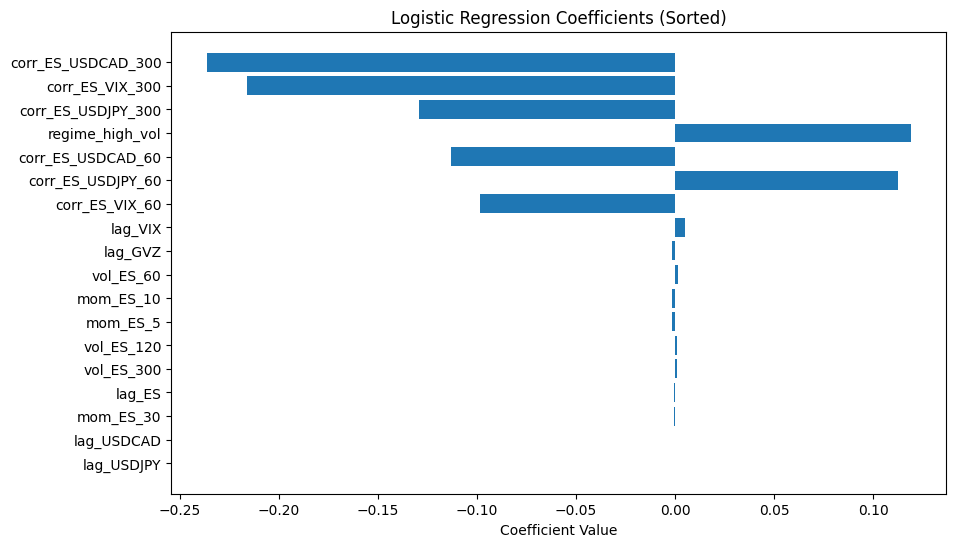

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(coef_table['feature'], coef_table['coefficient'])
plt.title("Logistic Regression Coefficients (Sorted)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

tscv = TimeSeriesSplit(n_splits=5)

rf_accuracies = []
rf_models = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=50,
        min_samples_leaf=25,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    rf_accuracies.append(acc)
    rf_models.append(rf)

rf_accuracies

[0.5971683447731567,
 0.5938153205940736,
 0.5603281276158133,
 0.5361299117499342,
 0.5324229306674958]

In [23]:
final_rf = rf_models[-1]

importances = final_rf.feature_importances_
rf_importance_table = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

rf_importance_table

,feature,importance
5,vol_ES_60,0.203716
6,vol_ES_120,0.125597
7,vol_ES_300,0.119492
13,corr_ES_USDCAD_300,0.086989
9,corr_ES_VIX_300,0.080840
17,regime_high_vol,0.063247
11,corr_ES_USDJPY_300,0.053890
12,corr_ES_USDCAD_60,0.045058
8,corr_ES_VIX_60,0.034069
10,corr_ES_USDJPY_60,0.029594


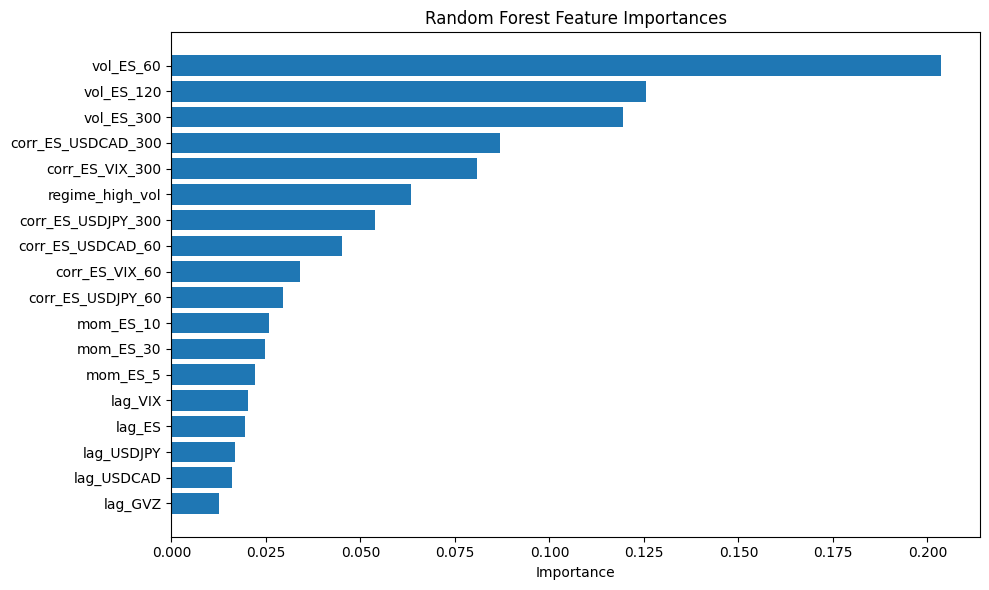

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_table["feature"], rf_importance_table["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [25]:
# Add the predicted labels from the final model
df_model['rf_pred'] = final_rf.predict(X)

# Evaluate accuracy by volatility regime
high_vol_acc = (df_model[df_model['regime_high_vol'] == 1]['rf_pred'] ==
                 df_model[df_model['regime_high_vol'] == 1][target]).mean()

low_vol_acc = (df_model[df_model['regime_high_vol'] == 0]['rf_pred'] ==
                df_model[df_model['regime_high_vol'] == 0][target]).mean()

high_vol_acc, low_vol_acc

/tmp/ipython-input-1040420197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['rf_pred'] = final_rf.predict(X)


(np.float64(0.5377459017482508), np.float64(0.5888414998718788))

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

# Baseline evaluation using the SAME time-series splits as the models
baseline_results = []

# We only need y for baselines, but we'll iterate with the same splits used for X, y
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ---- Majority-class baseline ----
    # Find which class (0 or 1) is most common in the TRAINING data
    majority_class = y_train.mode()[0]
    majority_preds = np.full(shape=len(y_test), fill_value=majority_class)
    majority_acc = accuracy_score(y_test, majority_preds)

    # ---- Random baseline ----
    # Draw random labels according to the TRAINING class distribution
    class_probs = y_train.value_counts(normalize=True)
    rng = np.random.RandomState(42 + fold)  # seed for reproducibility per fold
    random_preds = rng.choice(class_probs.index, size=len(y_test), p=class_probs.values)
    random_acc = accuracy_score(y_test, random_preds)

    baseline_results.append({
        "fold": fold,
        "majority_acc": majority_acc,
        "random_acc": random_acc
    })

baseline_df = pd.DataFrame(baseline_results)
baseline_df

,fold,majority_acc,random_acc
0,1,0.597293,0.522125
1,2,0.593959,0.521178
2,3,0.560448,0.511817
3,4,0.536187,0.507168
4,5,0.532394,0.503805


In [27]:
baseline_df[["majority_acc", "random_acc"]].mean()

,0
majority_acc,0.564056
random_acc,0.513218


In [29]:
# Define different feature groups for ablation
feature_groups = {
    "lags_only": [
        "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ"
    ],
    "lags_plus_ES_vol": [
        "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ",
        "vol_ES_60", "vol_ES_120", "vol_ES_300"
    ],
    "lags_ES_vol_plus_corr": [
        "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ",
        "vol_ES_60", "vol_ES_120", "vol_ES_300",
        "corr_ES_VIX_60", "corr_ES_VIX_300",
        "corr_ES_USDJPY_60", "corr_ES_USDJPY_300",
        "corr_ES_USDCAD_60", "corr_ES_USDCAD_300",
    ],
    "full_features": [
        # You can tweak this to match your favorite full set
        "lag_ES", "lag_USDJPY", "lag_USDCAD", "lag_VIX", "lag_GVZ",
        "vol_ES_60", "vol_ES_120", "vol_ES_300",
        "vol_VIX_60", "vol_VIX_120", "vol_VIX_300",
        "vol_USDJPY_60", "vol_USDJPY_120", "vol_USDJPY_300",
        "vol_USDCAD_60", "vol_USDCAD_120", "vol_USDCAD_300",
        "corr_ES_VIX_60", "corr_ES_VIX_300",
        "corr_ES_USDJPY_60", "corr_ES_USDJPY_300",
        "corr_ES_USDCAD_60", "corr_ES_USDCAD_300",
        "mom_ES_5", "mom_ES_10", "mom_ES_30",
        "regime_high_vol",
    ]
}

feature_groups

{'lags_only': ['lag_ES', 'lag_USDJPY', 'lag_USDCAD', 'lag_VIX', 'lag_GVZ'],
 'lags_plus_ES_vol': ['lag_ES',
  'lag_USDJPY',
  'lag_USDCAD',
  'lag_VIX',
  'lag_GVZ',
  'vol_ES_60',
  'vol_ES_120',
  'vol_ES_300'],
 'lags_ES_vol_plus_corr': ['lag_ES',
  'lag_USDJPY',
  'lag_USDCAD',
  'lag_VIX',
  'lag_GVZ',
  'vol_ES_60',
  'vol_ES_120',
  'vol_ES_300',
  'corr_ES_VIX_60',
  'corr_ES_VIX_300',
  'corr_ES_USDJPY_60',
  'corr_ES_USDJPY_300',
  'corr_ES_USDCAD_60',
  'corr_ES_USDCAD_300'],
 'full_features': ['lag_ES',
  'lag_USDJPY',
  'lag_USDCAD',
  'lag_VIX',
  'lag_GVZ',
  'vol_ES_60',
  'vol_ES_120',
  'vol_ES_300',
  'vol_VIX_60',
  'vol_VIX_120',
  'vol_VIX_300',
  'vol_USDJPY_60',
  'vol_USDJPY_120',
  'vol_USDJPY_300',
  'vol_USDCAD_60',
  'vol_USDCAD_120',
  'vol_USDCAD_300',
  'corr_ES_VIX_60',
  'corr_ES_VIX_300',
  'corr_ES_USDJPY_60',
  'corr_ES_USDJPY_300',
  'corr_ES_USDCAD_60',
  'corr_ES_USDCAD_300',
  'mom_ES_5',
  'mom_ES_10',
  'mom_ES_30',
  'regime_high_vol']}

In [30]:
from sklearn.linear_model import LogisticRegression

def eval_logistic_ablation(df_model, target_col, feature_list, n_splits=5):
    """
    Runs TimeSeriesSplit logistic regression on a subset of features.
    Returns mean accuracy and std over folds.
    """
    X_sub = df_model[feature_list]
    y_all = df_model[target_col]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    accs = []

    for train_idx, test_idx in tscv.split(X_sub):
        X_train, X_test = X_sub.iloc[train_idx], X_sub.iloc[test_idx]
        y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]

        clf = LogisticRegression(max_iter=2000)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        accs.append(accuracy_score(y_test, preds))

    return np.mean(accs), np.std(accs)

In [31]:
log_ablation_results = []

for group_name, feats in feature_groups.items():
    # Drop rows where any of the features or the target is NaN
    df_group = df_model.dropna(subset=feats + [target])

    mean_acc, std_acc = eval_logistic_ablation(
        df_model=df_group,
        target_col=target,
        feature_list=feats,
        n_splits=5
    )

    log_ablation_results.append({
        "group": group_name,
        "num_features": len(feats),
        "mean_accuracy": mean_acc,
        "std_accuracy": std_acc
    })

log_ablation_df = pd.DataFrame(log_ablation_results)
log_ablation_df

,group,num_features,mean_accuracy,std_accuracy
0,lags_only,5,0.564056,0.027535
1,lags_plus_ES_vol,8,0.564056,0.027535
2,lags_ES_vol_plus_corr,14,0.564014,0.027582
3,full_features,27,0.563923,0.027679
